In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import csv

from scipy.optimize import minimize
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.svm import SVC
from sklearn.svm import OneClassSVM as OCSVM
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression as LR

from xgboost import XGBClassifier

from SupervisedAD_methods import *

## Data

In [2]:
ratio = 0.75
data = generate_data(100, ratio=ratio, seed=0)

data.shape

(100, 3)

In [3]:
data_test = generate_data(100, ratio=ratio, fake_r=0.5, seed=100)

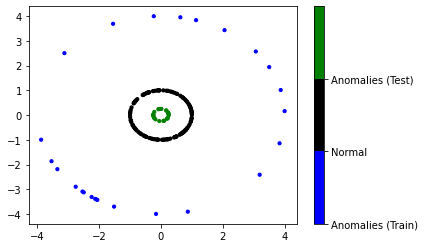

In [4]:
X = data[:, :-1]
y = data[:, -1]
x_test = data_test[:, :-1]
y_test = data_test[:, -1]

# for plotting: visualise 2 different OOD classes
y_test_transform = np.abs((y_test-1))+1

import matplotlib
x_plot = np.vstack((X, x_test))
colours = ["blue", "black", "green"]
plt.scatter(x_plot[:, 0], x_plot[:, 1], c=np.hstack((y, y_test_transform)),
            cmap=matplotlib.colors.ListedColormap(colours), s=10)
cb = plt.colorbar()
loc = np.arange(0, 2, 2/float(len(colours)))
cb.set_ticks(loc)
cb.set_ticklabels(["Anomalies (Train)", "Normal", "Anomalies (Test)"])
plt.show()

### For visualizations

In [5]:
lim = 2.25
grid = int(lim*100*2)
a = np.linspace(-lim, lim, grid)
xv, yv = np.meshgrid(a, a)
data_viz = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

radius_sq = (data_viz ** 2).sum(axis=1)
radius2 = (np.abs(radius_sq - 4) < 1e-1).reshape(grid, grid)
radius1 = (np.abs(radius_sq - 1) < 5e-2).reshape(grid, grid)
radius05 = (np.abs(radius_sq - 0.25) < 3e-2).reshape(grid, grid)

outcsv = open("heatmap_predictions.csv", mode="a")
writer = csv.writer(outcsv, delimiter=',', lineterminator='\n')


def viz_boundary(data_viz, y_pred, grid=grid, model_name="ES (RBF)"):

    transparency = 0.5
    plt.pcolormesh(radius2, cmap="YlGn", alpha=transparency)
    plt.pcolormesh(radius1, cmap="Greys", alpha=transparency)
    plt.pcolormesh(radius05, cmap="RdPu", alpha=transparency)

    y_im = y_pred.reshape(grid, grid)
    norm = matplotlib.colors.Normalize(y_pred.min(), y_pred.max())
    plt.pcolormesh(y_im, cmap="hot", norm=norm, alpha=0.6)
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    
    y_pred_pos = y_pred[radius1.reshape(-1) == 1]
    y_pred_neg = y_pred[radius1.reshape(-1) == 0]
    plt.hist(y_pred_pos, bins=100, label="Positive", alpha=0.5)
    plt.hist(y_pred_neg, bins=1000, label="Negative", alpha=0.5)
    plt.legend()
    plt.show()

    writer.writerow(np.hstack([[model_name], y_pred]))

In [6]:
# Use kernel for preprocessing
rbf = RBF()
x_kernel = rbf(X)
x_test_kernel = rbf(x_test, X)
x_viz = rbf(data_viz, X)

# Equality Separator with RBF kernel

## MSE

Train


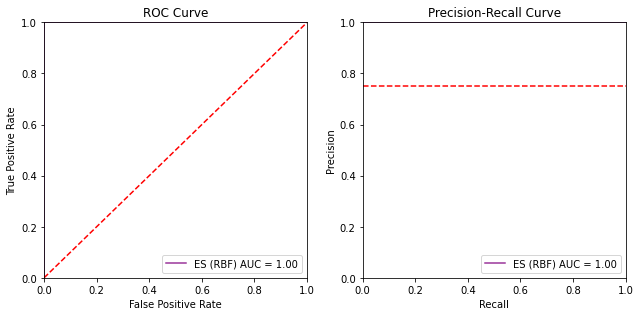

Test


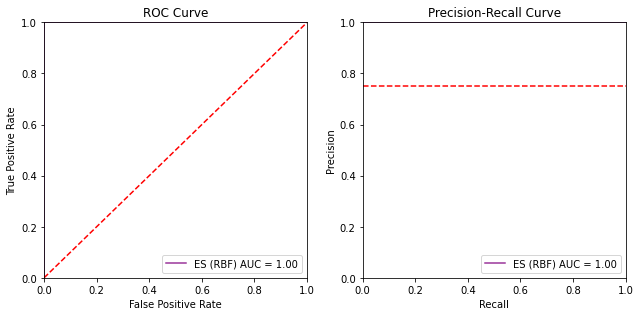

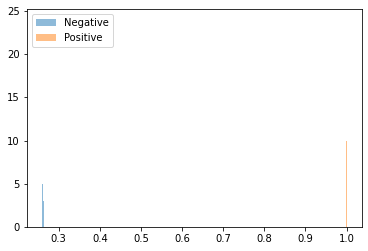

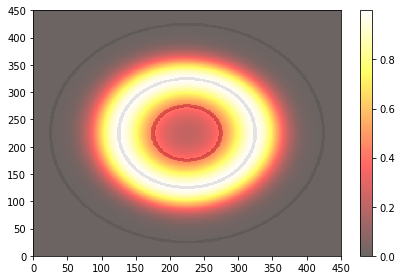

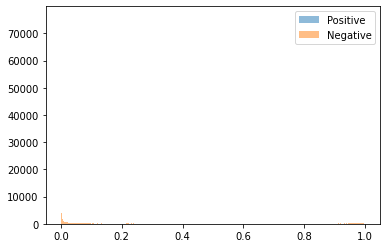

In [7]:
sigma = 10.
model_name = "ES (RBF)"

beta = not_that_deep(x_kernel, y, sigma=sigma, seed=148)

X_train = np.vstack((x_kernel.shape[0] * [1], x_kernel.T)).T
X_test = np.vstack((x_test_kernel.shape[0] * [1], x_test_kernel.T)).T
X_viz = np.vstack((x_viz.shape[0] * [1], x_viz.T)).T

print("Train")
y_pred = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))
eval_plot(y, y_pred, model_name)

print("Test")
y_pred = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))
eval_plot(y_test, y_pred, model_name)

y_pred_pos = y_pred[y_test == 1]
y_pred_neg = y_pred[y_test == 0]
plt.hist(y_pred_neg, bins=10, label="Negative", alpha=0.5)
plt.hist(y_pred_pos, bins=10, label="Positive", alpha=0.5)
plt.legend()
plt.show()

y_pred = np.exp(-0.5 * np.square(X_viz.dot(beta) / sigma))
viz_boundary(data_viz, y_pred, grid=grid, model_name=model_name)

In [8]:
aupr_train = []
aupr_test = []

sigma = 10.0

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='mse', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.9999999999999998 +- 1.1102230246251565e-16


In [9]:
aupr_train = []
aupr_test = []

sigma = 5.0

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='mse', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.9999999999999998 +- 1.1102230246251565e-16


In [10]:
aupr_train = []
aupr_test = []

sigma = 0.5

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='mse', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9817983690840141 +- 0.07933906977040804
Test AUPR
0.9983181988323289 +- 0.007330801333006927


In [11]:
aupr_train = []
aupr_test = []

sigma = 0.1

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='mse', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.8855426507229144 +- 0.20986944332957483
Test AUPR
0.9755289796877576 +- 0.04412375240993733


## Logistic loss

Train


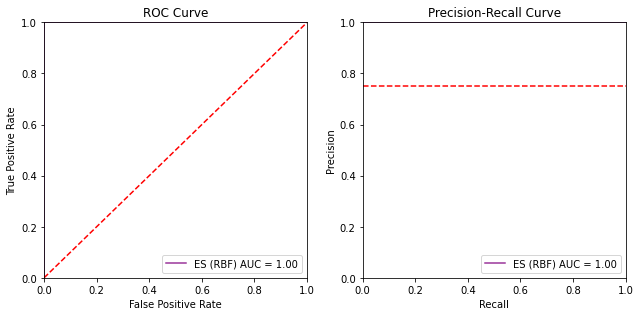

Test


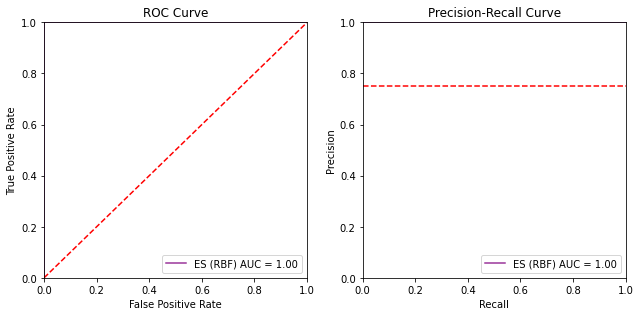

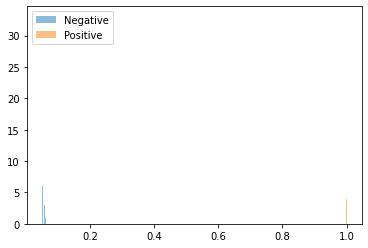

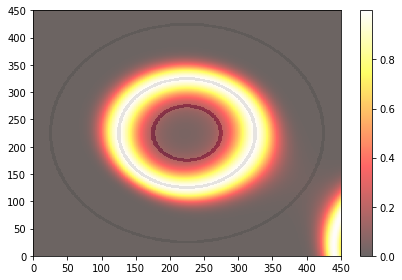

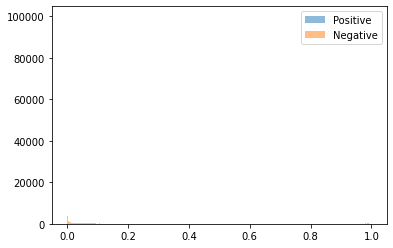

In [12]:
sigma = 10.
model_name = "ES (RBF)"

beta = not_that_deep(x_kernel, y, sigma=sigma, loss='bce', seed=148)

print("Train")
y_pred = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))
eval_plot(y, y_pred, model_name)

print("Test")
y_pred = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))
eval_plot(y_test, y_pred, model_name)

y_pred_pos = y_pred[y_test == 1]
y_pred_neg = y_pred[y_test == 0]
plt.hist(y_pred_neg, bins=10, label="Negative", alpha=0.5)
plt.hist(y_pred_pos, bins=10, label="Positive", alpha=0.5)
plt.legend()
plt.show()

y_pred = np.exp(-0.5 * np.square(X_viz.dot(beta) / sigma))
viz_boundary(data_viz, y_pred, grid=grid, model_name=model_name)

In [13]:
aupr_train = []
aupr_test = []

sigma = 10.0

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='bce', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.9962848611653115 +- 0.01619391474162992


In [14]:
aupr_train = []
aupr_test = []

sigma = 5.0

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='bce', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.9999999999999998 +- 1.1102230246251565e-16


In [15]:
aupr_train = []
aupr_test = []

sigma = 0.5

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='bce', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.9999999999999998 +- 1.1102230246251565e-16


In [16]:
aupr_train = []
aupr_test = []

sigma = 0.1

for i in range(20):
    
    beta = not_that_deep(x_kernel, y, sigma=sigma, loss='bce', seed=i)
    
    y_train = np.exp(-0.5 * np.square(X_train.dot(beta) / sigma))    
    aupr_train.append(eval_plot(y, y_train, "ES (RBF)", plot=False))

    y_es = np.exp(-0.5 * np.square(X_test.dot(beta) / sigma))    
    aupr_test.append(eval_plot(y_test, y_es, "ES (RBF)", plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

Train AUPR
0.9290768432913717 +- 0.17421925916238165
Test AUPR
0.9874199162298283 +- 0.031999346074670774


# Binary Classification Baselines

In [17]:
def cross_validate(x_train, x_test_input, x_viz, model, model_name, params):
    
    gridsearch = GridSearchCV(model, params, cv=10)
    gridsearch.fit(x_train, y)

    print("Train")
    y_pred = gridsearch.predict_proba(x_train)[:, 1]
    eval_plot(y, y_pred, model_name)

    print("Test")
    y_pred = gridsearch.predict_proba(x_test_input)[:, 1]
    eval_plot(y_test, y_pred, model_name)

    y_pred_pos = y_pred[y_test == 1]
    y_pred_neg = y_pred[y_test == 0]
    plt.hist(y_pred_neg, bins=10, label="Negative", alpha=0.5)
    plt.hist(y_pred_pos, bins=10, label="Positive", alpha=0.5)
    plt.legend()
    plt.show()

    y_pred = gridsearch.predict_proba(x_viz)[:, 1]
    viz_boundary(data_viz, y_pred, grid=grid, model_name=model_name)

    return gridsearch.best_params_

### Logistic Regression (Halfspace)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:132

Train


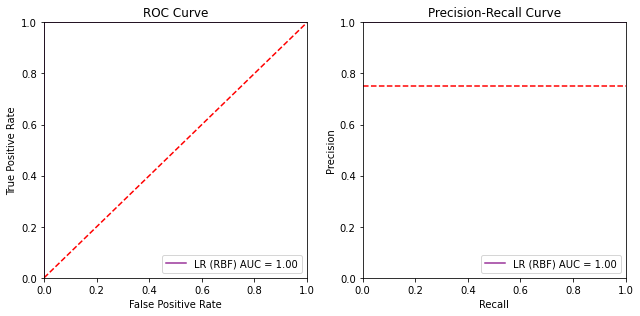

Test


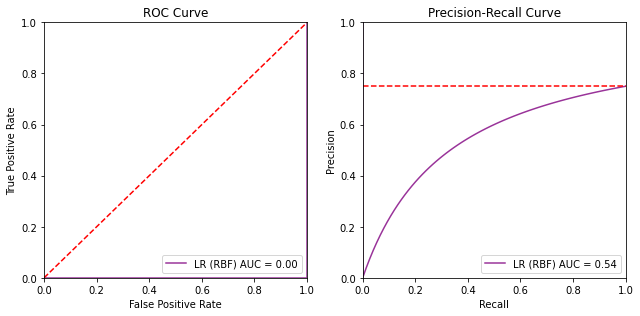

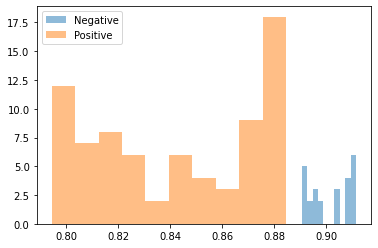

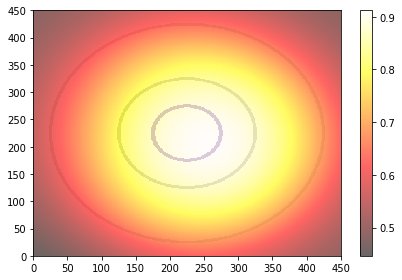

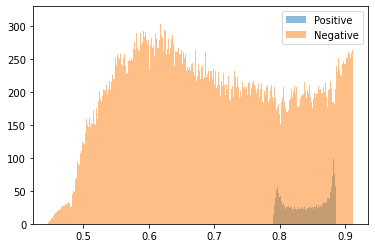

{'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.5378602200379621 +- 1.1102230246251565e-16


In [18]:
model_name = "LR (RBF)"
model = LR(random_state=0)
params = {"C": [0.01, 0.1, 1., 10., 100.],
          "class_weight": [None, "balanced"],
         "penalty": ["l2", 'none']}

best_params = cross_validate(x_kernel, x_test_kernel, x_viz, model, model_name, params)
print(best_params)

aupr_train = []
aupr_test = []

for i in range(20):

    model = LR(random_state=i, **best_params)
    model.fit(x_kernel, y)
    
    y_train = model.predict_proba(x_kernel)[:, 1]
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.predict_proba(x_test_kernel)[:, 1]
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))

print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## SVM

Train


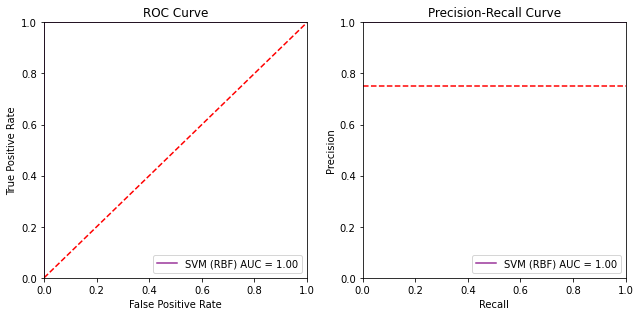

Test


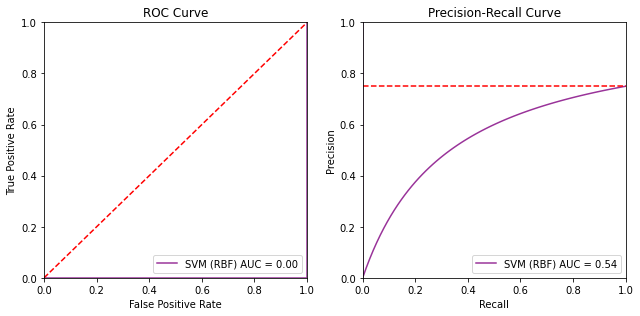

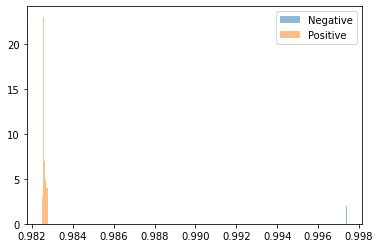

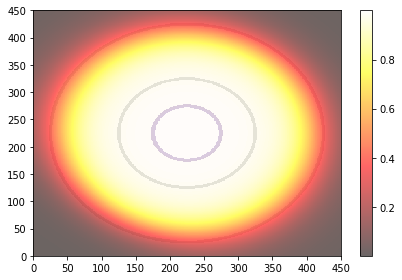

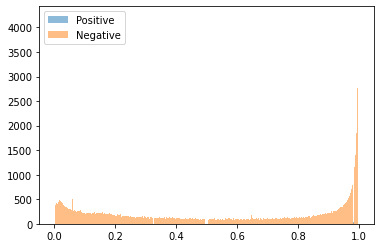

{'C': 0.1, 'class_weight': None}
Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.5378602200379621 +- 1.1102230246251565e-16


In [19]:
model_name = "SVM (RBF)"
model = SVC(probability=True, kernel='rbf', random_state=0)

params = {"C": [0.01, 0.1, 1., 10., 100.], "class_weight": [None, "balanced"]}

best_params = cross_validate(X, x_test, data_viz, model, model_name, params)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = SVC(probability=True, kernel='rbf', random_state=i, **best_params)
    model.fit(X, y)
    
    y_train = model.predict_proba(X)[:, 1]
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.predict_proba(x_test)[:, 1]
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## Decision Trees

Train


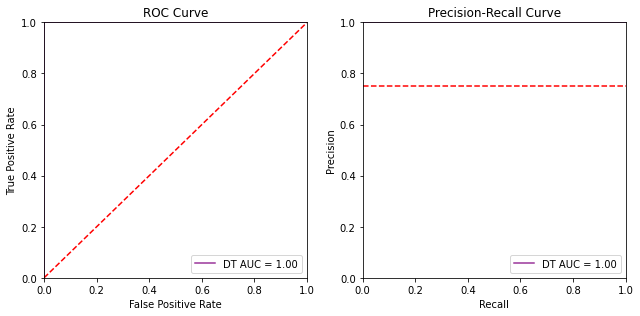

Test


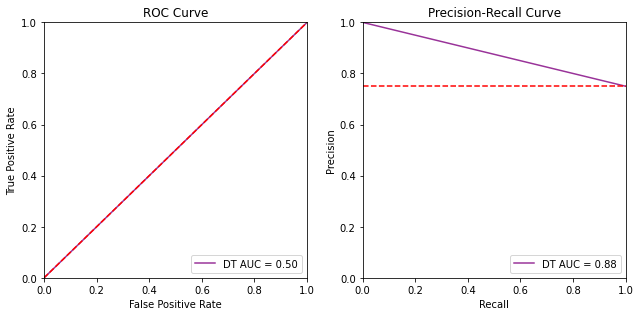

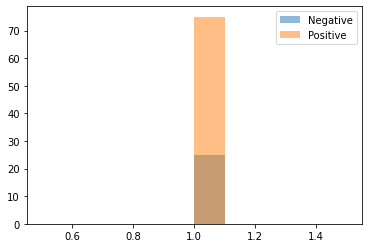

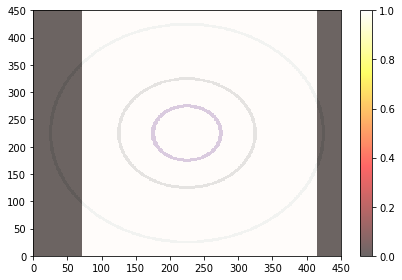

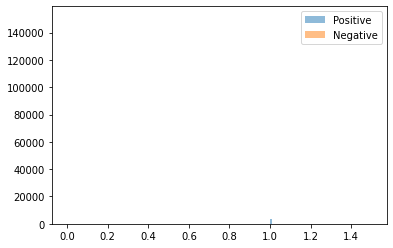

{'class_weight': None, 'max_depth': 8, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Train AUPR
0.9991060315714723 +- 0.0027071793487734954
Test AUPR
0.8694202239861362 +- 0.029109267092777315


In [20]:
model_name = "DT"
model = DecisionTreeClassifier(criterion='gini', random_state=0)

params = {"splitter": ["best", "random"],
          "max_depth": [4, 8, None],
          "min_samples_split": [2, 10],
          "min_samples_leaf": [1, 10],
          "max_features": [0.5, None],
          "max_leaf_nodes": [None, 4, 8],
          "class_weight": [None, "balanced"]}

best_params = cross_validate(X, x_test, data_viz, model, model_name, params)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = DecisionTreeClassifier(criterion='gini', random_state=i, **best_params)
    model.fit(X, y)
    
    y_train = model.predict_proba(X)[:, 1]
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.predict_proba(x_test)[:, 1]
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## Random Forest

Train


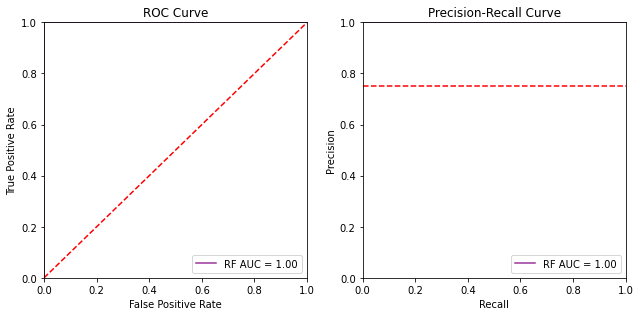

Test


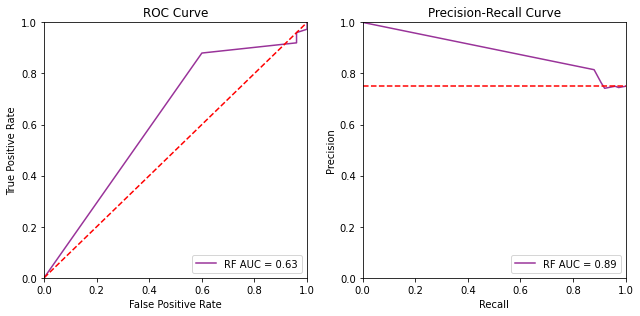

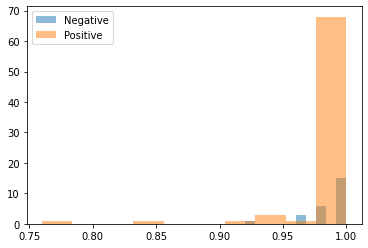

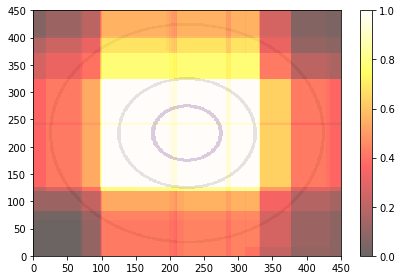

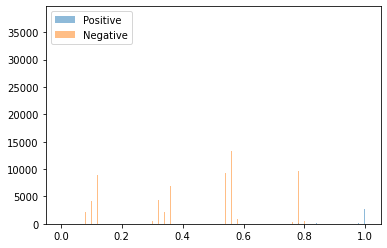

{'class_weight': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train AUPR
1.0 +- 0.0
Test AUPR
0.8754154868042979 +- 0.013133094750456058


In [21]:
model_name = "RF"
model = RandomForestClassifier(criterion='gini', random_state=0)

params = {"n_estimators": [50, 100],
          "min_samples_split": [2, 10],
          "min_samples_leaf": [1, 10],
          "max_features": [0.5, None],
          "max_leaf_nodes": [None, 4, 8],
          "class_weight": [None, "balanced", "balanced_subsample"]}

best_params = cross_validate(X, x_test, data_viz, model, model_name, params)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = RandomForestClassifier(criterion='gini', random_state=i, **best_params)
    model.fit(X, y)
    
    y_train = model.predict_proba(X)[:, 1]
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.predict_proba(x_test)[:, 1]
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## XGBoost Classifier

Train


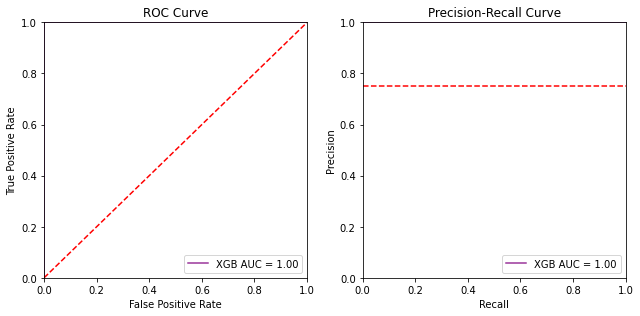

Test


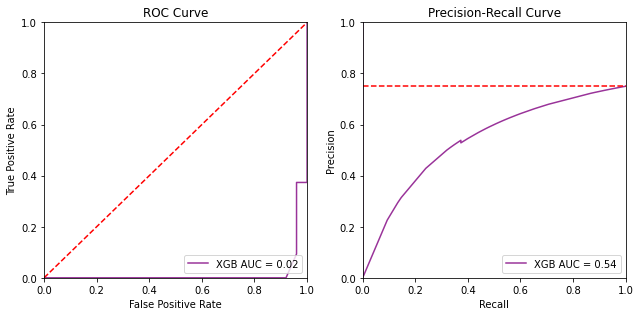

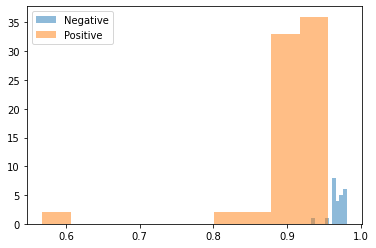

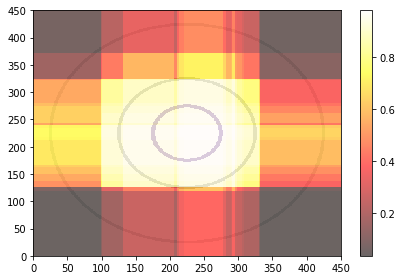

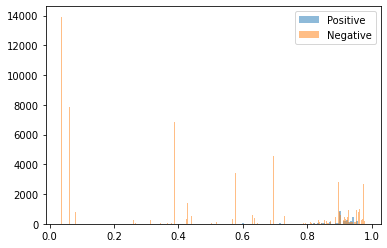

{'gamma': 0, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.01, 'scale_pos_weight': 0.25, 'subsample': 0.6}
Train AUPR
0.9999468990042673 +- 9.8693901736764e-05
Test AUPR
0.5455760606408246 +- 0.007876290101582594


In [22]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
model_name = "XGB"
model = XGBClassifier(objective='binary:logistic', random_state=0)

params = {"n_estimators": [50, 100],
          "subsample": [0.6, 0.9],
          "gamma": [0, 0.01, 0.1],
          "reg_alpha": [0, 0.01, 0.1],
          "reg_lambda": [0, 0.01, 0.1],
          "scale_pos_weight": [0.5, 0.25]}

best_params = cross_validate(X, x_test, data_viz, model, model_name, params)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = XGBClassifier(objective='binary:logistic', random_state=i, **best_params)
    model.fit(X, y)
    
    y_train = model.predict_proba(X)[:, 1]
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.predict_proba(x_test)[:, 1]
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

# Unsupervised Baselines

In [23]:
def cross_validate_unsupervised(Model, params_dict, model_name, seed=0):

    param_names = list(params_dict.keys())
    param_values = (zip(param_names, x) for x in product(*params_dict.values()))

    param_list = []
    cv_scores = []

    for paramset in param_values:
        
        params = dict(paramset)

        cv_scores.append(calculate_cv_score(Model, params, seed=seed))

        param_list.append(params)

    print("Get Min CV Score")
    i = np.argmin(cv_scores)
    params = param_list[i]
    
    # Visualization
    if seed:
        model = Model(random_state=seed, **params)
    else:
        model = Model(**params)
    
    model.fit(X)
    
    print("Train")
    y_pred = model.score_samples(X)
    eval_plot(y, y_pred, model_name)

    print("Test")
    y_pred = model.score_samples(x_test)
    eval_plot(y_test, y_pred, model_name)

    y_pred_pos = y_pred[y_test == 1]
    y_pred_neg = y_pred[y_test == 0]
    plt.hist(y_pred_neg, bins=10, label="Negative", alpha=0.5)
    plt.hist(y_pred_pos, bins=10, label="Positive", alpha=0.5)
    plt.legend()
    plt.show()

    y_pred = model.score_samples(data_viz)
    viz_boundary(data_viz, y_pred, grid=grid, model_name=model_name)
    
    return params


def calculate_cv_score(Model, params, seed=0):

    kf = StratifiedKFold(n_splits=10, shuffle=False)

    cv_loss = 0

    for train_indices, val_indices in kf.split(X, y):
        x_train, y_train = X[train_indices], y[train_indices]
        x_val, y_val = X[val_indices], y[val_indices]
        
        if seed:
            model = Model(random_state=seed, **params)
        else:
            model = Model(**params)
        model.fit(x_train)
        y_pred = model.score_samples(x_val)
        cv_loss += metrics.log_loss(y_val, y_pred)

    return cv_loss

## Isolation Forest

Get Min CV Score
Train


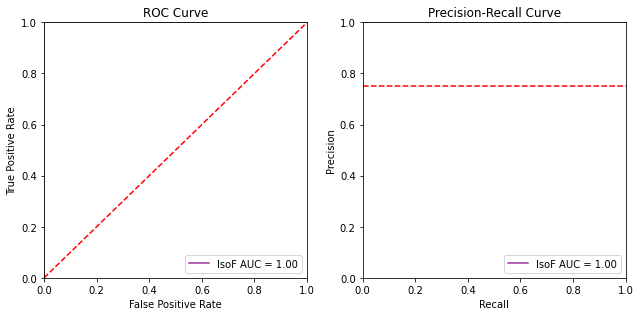

Test


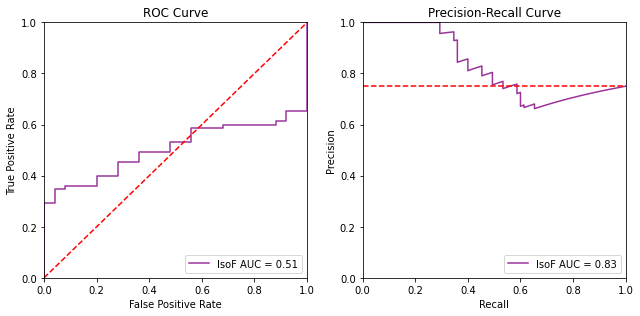

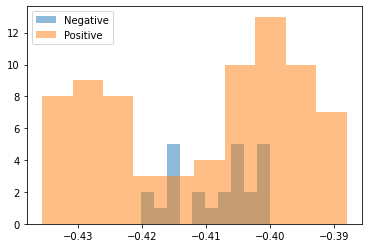

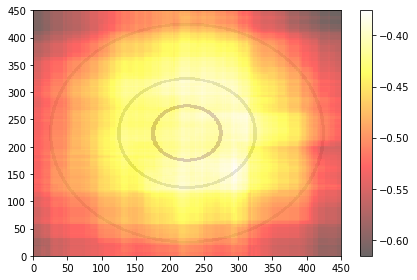

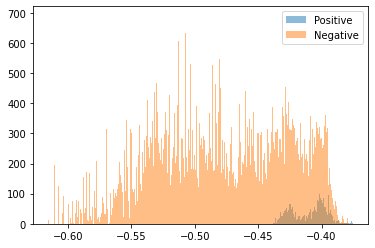

{'n_estimators': 50, 'contamination': 'auto', 'max_samples': 'auto', 'max_features': 1.0}
Train AUPR
0.9999999999999998 +- 1.1102230246251565e-16
Test AUPR
0.8584006310544832 +- 0.047505788110367396


In [24]:
model_name = "IsoF"
params_dict = {
    "n_estimators": [50, 100],
          "contamination": ["auto", 0.25],
          "max_samples": ["auto", 0.9, 1.],
          "max_features": [1.0]
         }

best_params = cross_validate_unsupervised(IsolationForest, params_dict, model_name, seed=0)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = IsolationForest(random_state=i, **best_params)
    model.fit(X)
    
    y_train = model.score_samples(X)
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.score_samples(x_test)
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## LOF

Get Min CV Score
Train


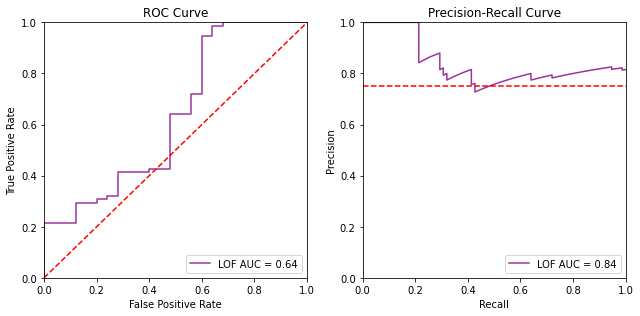

Test


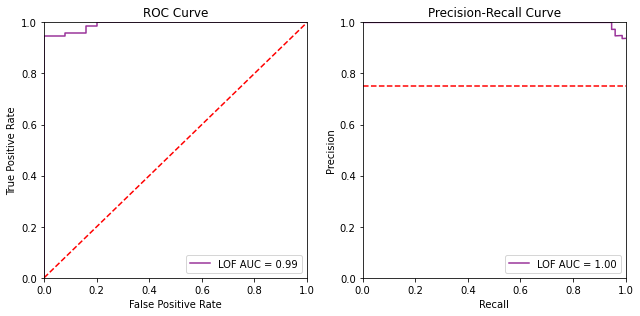

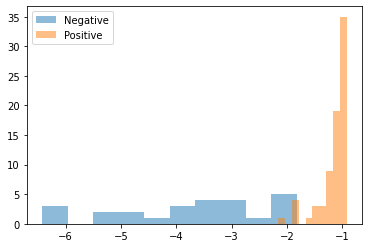

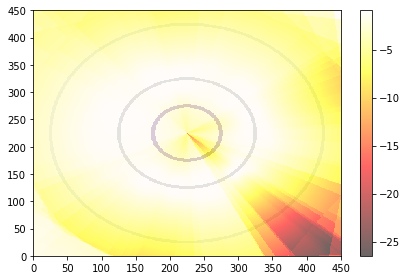

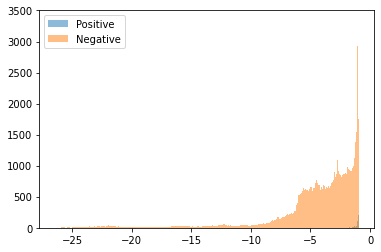

{'n_neighbors': 5, 'contamination': 'auto', 'leaf_size': 30, 'novelty': True}
Train AUPR
0.840998699710679 +- 1.1102230246251565e-16
Test AUPR
0.9974131655955532 +- 0.0


In [25]:
model_name ="LOF"
params_dict = {
    "n_neighbors": [5, 10, 15],
    "contamination": ["auto", 0.25],
    "leaf_size": [30, 8],
    "novelty": [True]
         }

best_params = cross_validate_unsupervised(LOF, params_dict, model_name, seed=False)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = LOF(**best_params)
    model.fit(X)
    
    y_train = model.score_samples(X)
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.score_samples(x_test)
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

## OCSVM

Get Min CV Score
Train


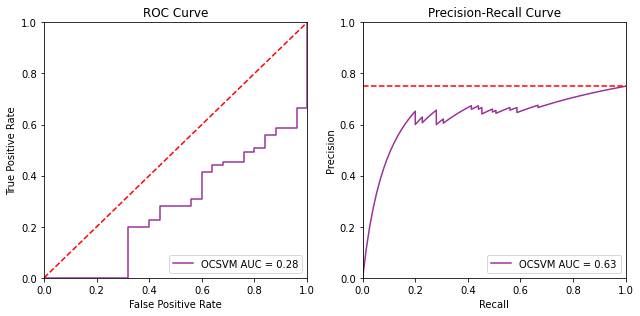

Test


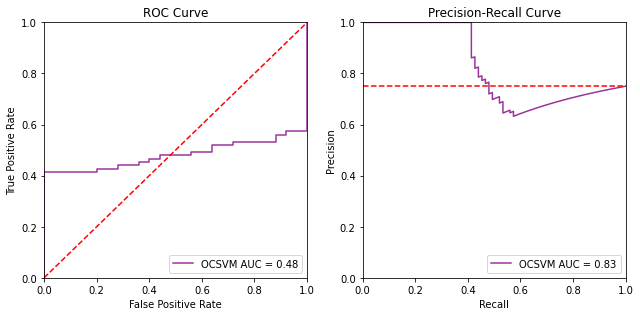

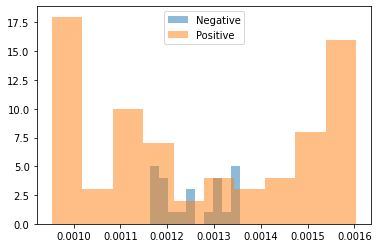

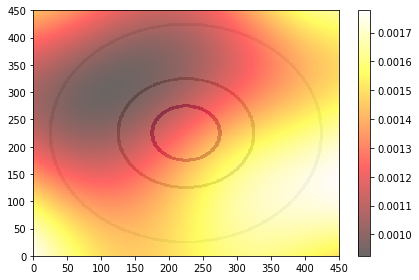

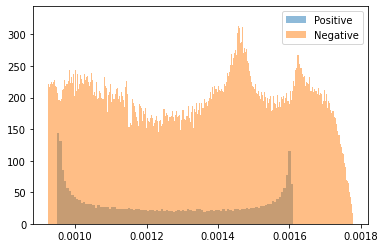

{'kernel': 'rbf', 'nu': 0.0001, 'gamma': 'scale', 'shrinking': True}
Train AUPR
0.6264739377226362 +- 0.0
Test AUPR
0.828508395821593 +- 1.1102230246251565e-16


In [26]:
model_name ="OCSVM"
params_dict = {
    "kernel": ["rbf"],
    "nu": [0.0001, 0.25],
    "gamma": ["auto", "scale"],
    "shrinking": [True, False]
         }

best_params = cross_validate_unsupervised(OCSVM, params_dict, model_name, seed=False)
print(best_params)

aupr_test = []
aupr_train = []

for i in range(20):

    model = OCSVM(**best_params)
    model.fit(X)
    
    y_train = model.score_samples(X)
    aupr_train.append(eval_plot(y, y_train, model_name, plot=False))

    y_pred = model.score_samples(x_test)
    aupr_test.append(eval_plot(y_test, y_pred, model_name, plot=False))
    
print("Train AUPR")
print(f"{np.mean(aupr_train)} +- {np.std(aupr_train)}")

print("Test AUPR")
print(f"{np.mean(aupr_test)} +- {np.std(aupr_test)}")

outcsv.close()